# Implementing a new helical magnetic field

In this notebook, a new (and more general) helical magnetic field is implemented. This is a *cylindrical force-free field*, constructed using Chandrasekhar-Kendall function. 

It is given by:

$$ B_r(r,\phi, z) = -\frac{B}{\gamma}\left[\frac{m\lambda}{\gamma r} J_m(\gamma r) +kJ_m'(\gamma r)\right] \sin(m\phi+kz) $$

$$ B_\phi(r,\phi, z) = -\frac{B}{\gamma}\left[\frac{mk}{\gamma r} J_m(\gamma r) +\lambda J_m'(\gamma r)\right] \cos(m\phi+kz) $$

$$ B_z(r,\phi, z) = B J_m(\gamma r)\cos(m\phi+kz) $$

Where $J_m$ is the Bessel function of first kind.

## Testing the new field
### Basic imports and grid

In [1]:
import os, sys
sys.path.append('../')

import imagine as img
import numpy as np
import astropy.units as u
import shell
from shell.CK_field import CK_magnetic_field
import shell.visualization as visu
import matplotlib.pyplot as plt

In [2]:

L = 70*u.pc
N = 128

grid = img.fields.UniformGrid(# coordinate values for edges of the grid box
                       box=[[-L,L],[-L,L],[-L,L]], 
                       # Grid resolution
                       resolution=[N, N, N])


### Inspecting the CK field 

First let us look at an arbitrarily complicated case: $\,m=1$, $\,k = 0.05\,{\rm pc}^{-1}$ and $\,\gamma = 0.1\,{\rm pc}^{-1}$  (I chose small periods so that the oscilations are evident within the box).

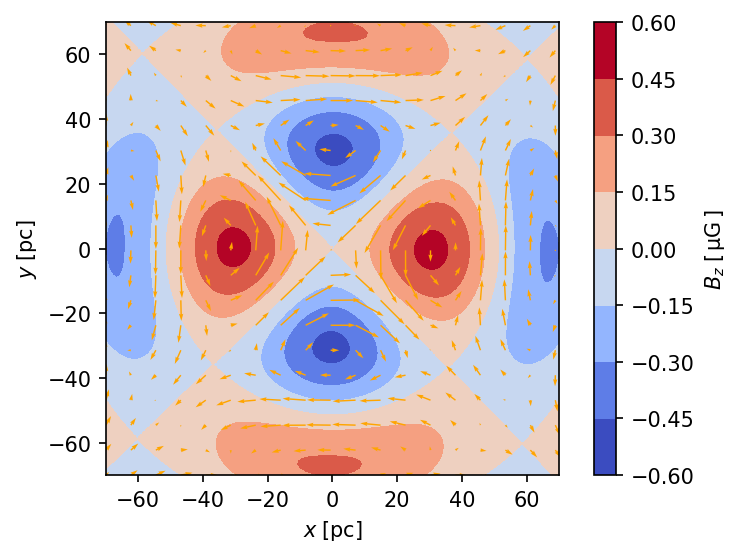

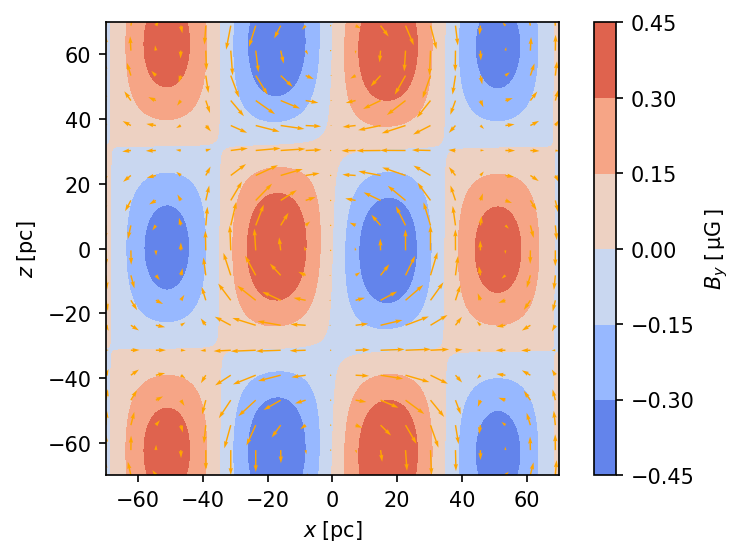

In [3]:
Bx, By, Bz = CK_magnetic_field(grid, period=10*u.pc, period_z=20*u.pc, m=2)

visu.plot_vector_xy(grid, [Bx, By, Bz], skip=7, show_z_component=True, name='B_z');
visu.plot_vector_xz(grid, [Bx, By, Bz], skip=7, show_y_component=True, name='B_y');

Now the simplest case, known as *Bessel Function Model*, where $m=0$, $k=0$ and 
$\gamma=0.1\, {\rm pc}^{-1}$.

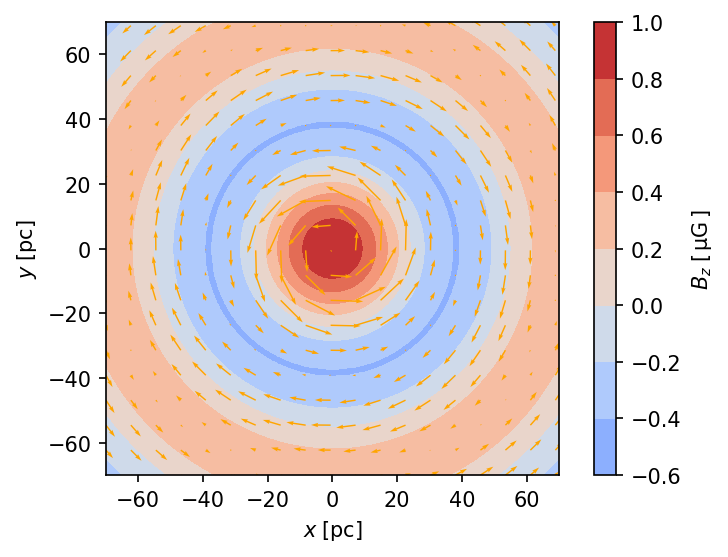

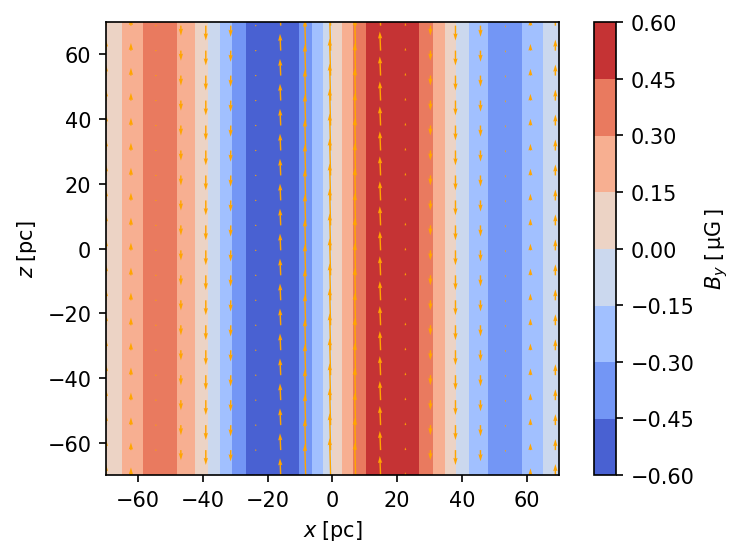

In [4]:
Bx, By, Bz = CK_magnetic_field(grid, period=10*u.pc, period_z=np.inf*u.pc, m=0.0)

visu.plot_vector_xy(grid, [Bx, By, Bz], skip=7, show_z_component=True, name='B_z');
visu.plot_vector_xz(grid, [Bx, By, Bz], skip=7, show_y_component=True, name='B_y');

Because we want to explore this case in detail, I have implemented an specialized (and much simplified) function `BMF_magnetic_field` which corresponds to the case $m=0$ and $k=0$ but runs (slightly) faster.

In [5]:
from shell.CK_field import BMF_magnetic_field

Bx_bmf, By_bmf, Bz_bmf = BMF_magnetic_field(grid, period=10*u.pc)

We can check that this leads to the same results (the following would lead to errors if things were different):

In [6]:
assert np.allclose(Bx_bmf, Bx)
assert np.allclose(By_bmf, By)
assert np.allclose(Bz_bmf, Bz)

The performance difference was, however, very disappointing:

In [7]:
%timeit BMF_magnetic_field(grid, period=10*u.pc)
%timeit CK_magnetic_field(grid, period=10*u.pc)

2.43 s ± 399 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.54 s ± 2.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## IMAGINE CK fields

The associated IMAGINE fields were implemented, as exemplified below:

In [8]:
import imagine_snrs as img_snrs

In [9]:
# Parameters dictionary, including shell parameters
parameters = {'initial_electron_density': 0.01*u.cm**-3,
              'shell_V0':0.0153*u.pc/u.yr, 
              'shell_a': 1.3, 
              'shell_b': 10,
              'elapsed_time': 1300*u.yr,
              'shell_radius': 35*u.pc}

# Creates the IMAGINE Field object
ne_field = img_snrs.fields.SNRThermalElectrons(grid, parameters=parameters)
ne_field.get_data(); # This needs to be executed at least once in order for the rest to work

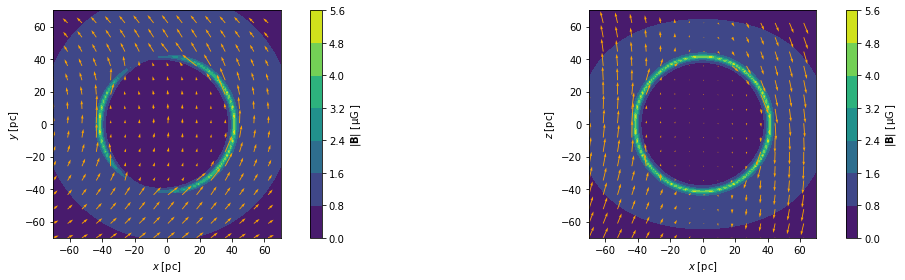

In [10]:
parameters_CK = {'B': 1*u.microgauss, 
                 'm': 0, 
                 'period': 50*u.pc,
                 'period_z': 100*u.pc,
                 'x_shift': 0*u.pc, 
                 'y_shift': 5*u.pc,
                 'z_shift': 0*u.pc,
                 'alpha': 90*u.deg, 
                 'beta': 0, 
                 'gamma': 0}

B_CK = img_snrs.fields.SNR_CK_MagneticField(grid, parameters=parameters_CK)
b_ck = B_CK.get_data(dependencies={img_snrs.fields.SNRThermalElectrons: ne_field})
b_ck_list = [b_ck[:,:,:,i] for i in range(3)]

plt.figure(figsize=(16,4))
ax1, ax2 = plt.subplot(1,2,1), plt.subplot(1,2,2)
shell.visualization.plot_vector_xy(grid, b_ck_list, skip=8, ax=ax1);
shell.visualization.plot_vector_xz(grid, b_ck_list, skip=8, ax=ax2);
plt.tight_layout()

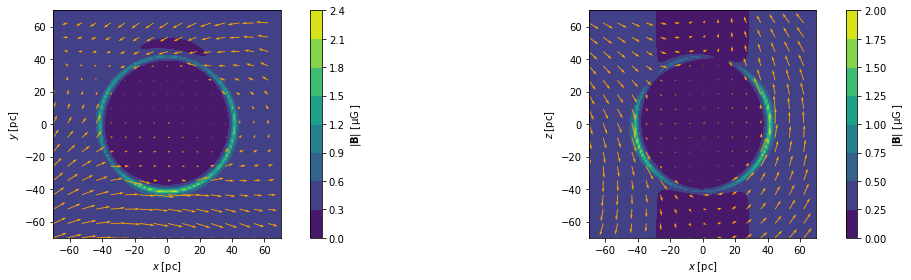

In [11]:
parameters_CK = {'B': 1*u.microgauss, 
                 'm': 2, 
                 'period': 50*u.pc,
                 'period_z': 100*u.pc,
                 'x_shift': 0*u.pc, 
                 'y_shift': 15*u.pc,
                 'z_shift': 30*u.pc,
                 'alpha': 90*u.deg, 
                 'beta': 30*u.deg, 
                 'gamma': -15*u.deg}

B_CK = img_snrs.fields.SNR_CK_MagneticField(grid, parameters=parameters_CK)
b_ck = B_CK.get_data(dependencies={img_snrs.fields.SNRThermalElectrons: ne_field})
b_ck_list = [b_ck[:,:,:,i] for i in range(3)]

plt.figure(figsize=(16,4))
ax1, ax2 = plt.subplot(1,2,1), plt.subplot(1,2,2)
shell.visualization.plot_vector_xy(grid, b_ck_list, skip=8, ax=ax1);
shell.visualization.plot_vector_xz(grid, b_ck_list, skip=8, ax=ax2);
plt.tight_layout()

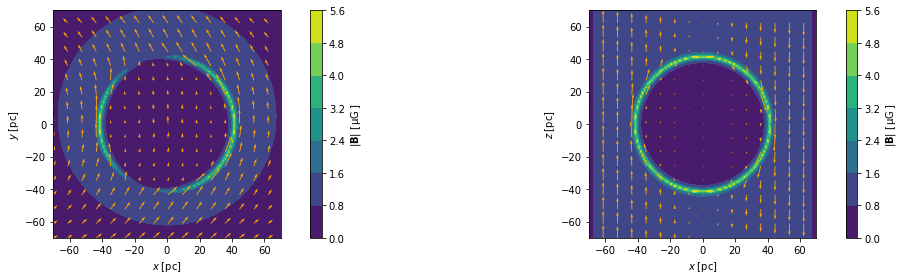

In [13]:
parameters_BMF = {'B': 1*u.microgauss, 
                 'period': 50*u.pc,
                 'x_shift': 0*u.pc, 
                 'y_shift': 5*u.pc,
                 'alpha': 90*u.deg, 
                 'beta': 0}

B_CK = img_snrs.fields.SNR_BMF_MagneticField(grid, parameters=parameters_BMF)
b_ck = B_CK.get_data(dependencies={img_snrs.fields.SNRThermalElectrons: ne_field})
b_ck_list = [b_ck[:,:,:,i] for i in range(3)]

plt.figure(figsize=(16,4))
ax1, ax2 = plt.subplot(1,2,1), plt.subplot(1,2,2)
shell.visualization.plot_vector_xy(grid, b_ck_list, skip=8, ax=ax1);
shell.visualization.plot_vector_xz(grid, b_ck_list, skip=8, ax=ax2);
plt.tight_layout()